In [1]:
%display typeset

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math

In [3]:
from sage.calculus.desolvers import desolve_system_rk4

Utilizando dados de Manaus e Vivax:

T1: 27.4

R1: 196.9

Tmin: 14.5

N: 8557

In [4]:
# Dados originais do artigo Modelling Climate Change and Malaria Transmission de Parham & Michael

# Definindo as constantes
num_steps = 50 # Tempo total
dt = 1 # Tamanho do passo

T1 = 23.2  # Temperatura média na ausência de sazonalidade (˚C)
T2 = 0.07  # Amplitude da variabilidade sazonal na temperatura
omega1 = 0.67  # Frequência angular das oscilações sazonais na temperatura (meses^–1)
phi1 = 1.53  # "Phase lag" da variabilidade da temperatura (defasagem de fase)
R1 = 85.9  # Precipitação mensal média na ausência de sazonalidade (mm)
R2 = 0.98  # Amplitude da variabilidade sazonal na precipitação
omega2 = 0.65  # Frequência angular das oscilações sazonais na precipitação (meses^–1)
phi2 = 1.99  # "Phase lag" da variabilidade da precipitação (defasagem de fase)

B_E = 200 # Número de ovos colocados por adulto por oviposição
p_ME = 0.9 # Probabilidade de sobrevivência dos ovos
p_ML = 0.25 # Probabilidade de sobrevivência das larvas
p_MP = 0.75 # Probabilidade de sobrevivência dos pupas
tau_E = 1 # Duração da fase de desenvolvimento dos ovos
tau_P = 1 # Duração da fase de desenvolvimento das pupas
c1 = 0.00554 # Constante (˚C dias)^-1
c2 = -0.06737 # Constante (dias)^-1

D1 = 36.5 # Valor fixo
b1 = 0.04 # Proporção de picadas de mosquitos suscetíveis em humanos infectados que resultam em infecção
A = -0.03 # Constante (˚C^2 dias)^-1
B = 1.31 # Constante (˚C dias)^-1
C = -4.4 # Constante (dias)^-1
b2 = 0.09 # Proporção de picadas de mosquitos infectados em humanos suscetíveis que resultam em infecção
tau_H = 10 # Período latente de infecção em humanos
DD = 111 # "Degree days" para desenvolvimento do parasita
Tmin = 16 # Temperatura mínima (abaixo dessa temperatura não há desenvolvimento do parasita)
gamma = 1/120 # 1/Duração média da infecciosidade humana em dias
R_L = 50 # Chuva limite até que os sítios de reprodução sejam eliminados, removendo indivíduos de estágio imaturo

N = 1000  # Número total de humanos
M = 10000  # Número total de mosquitos
I_M0 = M  # Número inicial de mosquitos infectados
I_H0 = 10  # Número inicial de humanos infectados
S_H0 = N - I_H0 # Número inicial de pessoas suscetíveis

-104.14696578994615
-100.88388229358684
-98.75111640168299
-98.59250860500427
-100.38143034468827
-103.4076614633409
-106.60899929828865
-108.80448414553308
-108.99443018562413
-106.90441736956072
-103.35401074129936
-99.90584036424653
-98.00897958275159
-98.34406515457658
-100.7142314068963
-104.27376524987493
-107.76321371596768
-109.76381074969308
-109.25281401401692
-106.29909571901237
-102.18941604728514
-98.71988686014267
-97.26543480923003
-98.30120537424627
-101.43111895062245
-105.57971613553283
-109.18301249672778
-110.63271282183031
-109.1092418896714
-105.21392137570726
-100.69199551545316
-97.44749006548649
-96.68756056146233
-98.64222897951818
-102.6497854646636
-107.29044448576043
-110.6670468622128
-111.15993060801242
-108.4101048797558
-103.64739146012573
-98.97378162942914
-96.25877883270931
-96.46389950746341
-99.51941363654478
-104.3979898070826
-109.25308020809379
-111.94908393142624
-111.12484316828098
-107.09126193730927
-101.68591553160041
-97.20619392291358
-95

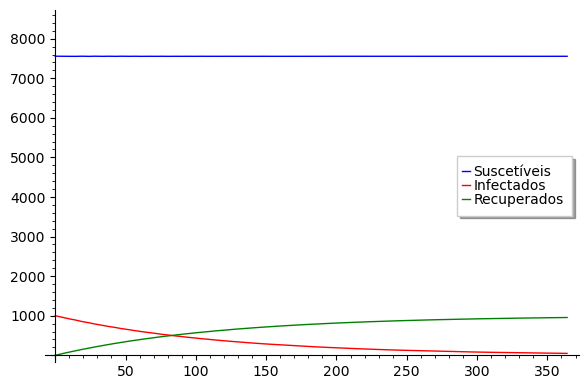

In [13]:
def run_simulation(num_steps=365, dt=1, T1=27.4, T2=0.025, omega1=0.67, phi1=1.53, R1=196.9, R2=-0.033, omega2=0.65, phi2=1.99,
                   B_E=200, p_ME=0.9, p_ML=0.25, p_MP=0.75, tau_E=1, tau_P=1, c1=0.00554, c2=-0.06737,
                   D1=36.5, b1=0.04, A=-0.03, B=1.31, C=-4.4, b2=0.09, tau_H=10, DD=105, Tmin=14.5, gamma=1/120, R_L = 50,
                   N=8557, M=10000, I_M0=None, I_H0=1000):
    
    # Definindo as constantes
    if I_M0 is None:
        I_M0 = M / 100

    S_H0 = N - I_H0

    # Funções de temperatura e chuva
    def T(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def R(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    # Duração da fase de desenvolvimento das larvas
    def tau_L(T):
        return 1 / (c1 * T + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(T):
        return np.exp(-1 / (A*T**2 + B*T + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(T):
        return np.exp(-(c1 * T + c2))
    
    def p_LR(R):
        return (4*p_ML/R_L**2) * R * (R_L - R)
    
    def p_LRT(R,T):
        return p_LR(R)*p_LT(T)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(R):
        return (4*p_ME/R_L**2) * R * (R_L - R)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(R):
        return (4*p_MP/R_L**2) * R * (R_L - R)

    # Duração do ciclo esporogônico
    def tau_M(T):
        return DD / (T - Tmin)

    # Definindo a função de sobrevivência do mosquito
    def l(tau_M, T):  
        p_T = p(T)
        return p_T**tau_M

    # Definindo a taxa de mortalidade do mosquito
    def mu(T):
        return -log(p(T))

    # Simulando as equações diferenciais
    S_H = [S_H0]
    I_H = [I_H0]
    R_H = [0]
    times = [0]

    for t in range(1, num_steps):
        # Atualiza a temperatura e a chuva
        T_curr = T(t * dt)
        R_curr = R(t * dt)

        # Calcular a taxa de mordida e probabilidade de transmissão
        a = (T_curr - T1) / D1
        b = B_E * p_ME * p_LRT(R_curr,T_curr) * p_MP / (tau_E + tau_L(T_curr) + tau_P)
        #rint(b)
        
        # b = B_E * p_E(R_curr) * p_LRT(R_curr,T_curr) * p_P(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
        # p_E(R), p_P(R) = ?
        
        if t < tau_H:
            dS_H = -a * b2 * (I_M0 / N) * S_H[-1]
            dI_H = a * b2 * (I_M0 / N) * S_H[-1] - gamma * I_H[-1]
        else:
            dS_H = -a * b2 * (I_H[t - tau_H] / N) * S_H[t - tau_H]
            dI_H = a * b2 * (I_H[t - tau_H] / N) * S_H[t - tau_H] - gamma * I_H[-1]
        dR_H = gamma * I_H[-1]

        # Atualize as populações
        S_H.append(S_H[-1] + dt * dS_H)
        I_H.append(I_H[-1] + dt * dI_H)
        R_H.append(R_H[-1] + dt * dR_H)
        times.append(t * dt)

    # Calculando R_0
    def calculate_R0(M, a, b1, b2, T, gamma, N): # , mu)
        tau_M_T = tau_M(T)
        l_tau_M = l(tau_M_T, T)  
        R_0 = (M * a**2 * b1 * b2 * l_tau_M) / (gamma * mu(T) * N)
        return R_0

    R_0 = calculate_R0(M, a, b1, b2, T1, gamma, N)  # , mu)
    print(f"R_0: {R_0}")

    # Calcular prevalências de equilíbrio
    I_M_star = M * (R_0 - 1) / ((R_0 / l(DD / (T1 - Tmin), T1)) + (a * b2 * M / (gamma * N)))
    I_H_star = N * (R_0 - 1) / (R_0 + (a * b1 / mu(T1)))

    print(f"Prevalência de equilíbrio para mosquitos: {I_M_star}")
    print(f"Prevalência de equilíbrio para humanos: {I_H_star}")

    times = [i*dt for i in range(num_steps)]

    # Criar os gráficos
    p1 = line(zip(times, S_H), color='blue', legend_label='Suscetíveis')
    p2 = line(zip(times, I_H), color='red', legend_label='Infectados')
    p3 = line(zip(times, R_H), color='green', legend_label='Recuperados')

    # Combinar os gráficos e mostrar o resultado
    (p1 + p2 + p3).show(xmin=0, xmax=num_steps*dt, ymin=0, ymax=N)

# Executar a simulação com os parâmetros padrão
run_simulation()

R_0: 0.013265476102818355
Prevalência de equilíbrio para mosquitos: 4627.473574037336
Prevalência de equilíbrio para humanos: 4411398.21832882


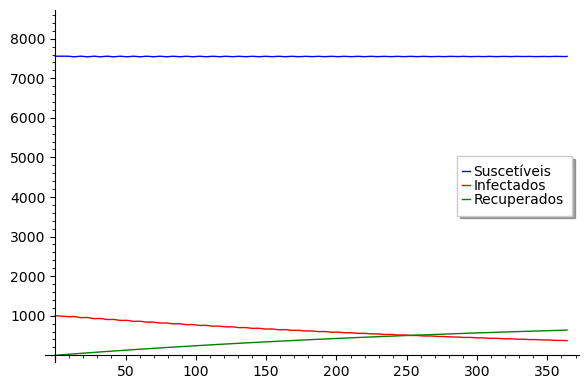

In [10]:
run_simulation(num_steps=365, dt=1, T1=27.4, T2=0.025, omega1=0.67, phi1=1.53, R1=196.9, R2=-0.033, omega2=0.65, phi2=1.99,
                   B_E=200, p_ME=0.9, p_ML=0.25, p_MP=0.75, tau_E=1, tau_P=1, c1=0.00554, c2=-0.06737,
                   D1=36.5, b1=0.1, A=-0.03, B=1.31, C=-4.4, b2=0.3, tau_H=10, DD=105, Tmin=14.5, gamma=1/365, R_L = 50,
                   N=8557, M=10000, I_M0=None, I_H0=1000)

-215281.42208090393
-191450.2350939781
-180688.56438687
-185663.21595598798
-205016.36940997798
-233079.19166531134
-259250.33980279916
-271060.08718962397
-261787.0611722065
-236157.55423536326
-206927.04227750681
-186028.81931419863
-179757.56394236663
-189441.52015275025
-212597.84782671067
-242099.3822752572
-265942.9226981225
-271906.4137031918
-256195.75011825483
-227162.47808324874
-198749.35152126517
-181559.29366075227
-180145.751546883
-194646.19706520447
-221383.73841306538
-251511.39645626704
-271656.0998333194
-270689.0435679775
-248712.7075294487
-217472.2642044313
-191077.4832942712
-178302.76479329195
-182083.33386710897
-201477.58982922861
-231385.72327532846
-260916.98427167817
-275698.96443128
-266976.5349235356
-239467.73245969694
-207501.3722547718
-184287.31920582848
-176549.75231947808
-185829.3692708284
-210090.1052510511
-242401.63518417548
-269626.0422876191
-277314.6012685836
-260571.56507256808
-228839.6420486331
-197759.1434811938
-178772.17635842593
-17660

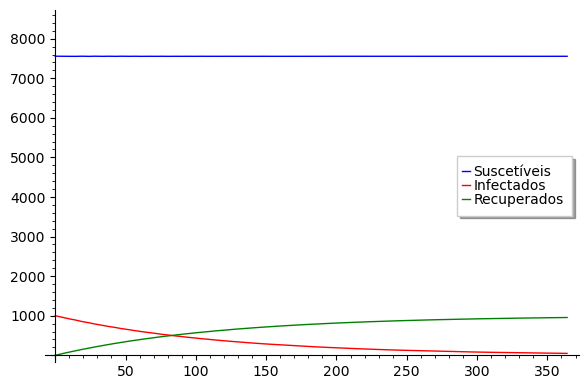

In [12]:
def run_simulation(num_steps=365, dt=1, T1=27.4, T2=0.025, omega1=0.67, phi1=1.53, R1=196.9, R2=-0.033, omega2=0.65, phi2=1.99,
                   B_E=200, p_ME=0.9, p_ML=0.25, p_MP=0.75, tau_E=1, tau_P=1, c1=0.00554, c2=-0.06737,
                   D1=36.5, b1=0.04, A=-0.03, B=1.31, C=-4.4, b2=0.09, tau_H=10, DD=105, Tmin=14.5, gamma=1/120, R_L = 50,
                   N=8557, M=10000, I_M0=None, I_H0=1000):
    
    # Definindo as constantes
    if I_M0 is None:
        I_M0 = M / 100

    S_H0 = N - I_H0

    # Funções de temperatura e chuva
    def T(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def R(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    # Duração da fase de desenvolvimento das larvas
    def tau_L(T):
        return 1 / (c1 * T + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(T):
        return np.exp(-1 / (A*T**2 + B*T + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(T):
        return np.exp(-(c1 * T + c2))
    
    def p_LR(R):
        return (4*p_ML/R_L**2) * R * (R_L - R)
    
    def p_LRT(R,T):
        return p_LR(R)*p_LT(T)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_E(R):
        return (4*p_ME/R_L**2) * R * (R_L - R)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_P(R):
        return (4*p_MP/R_L**2) * R * (R_L - R)

    # Duração do ciclo esporogônico
    def tau_M(T):
        return DD / (T - Tmin)

    # Definindo a função de sobrevivência do mosquito
    def l(tau_M, T):  
        p_T = p(T)
        return p_T**tau_M

    # Definindo a taxa de mortalidade do mosquito
    def mu(T):
        return -log(p(T))

    # Simulando as equações diferenciais
    S_H = [S_H0]
    I_H = [I_H0]
    R_H = [0]
    times = [0]

    for t in range(1, num_steps):
        # Atualiza a temperatura e a chuva
        T_curr = T(t * dt)
        R_curr = R(t * dt)

        # Calcular a taxa de mordida e probabilidade de transmissão
        a = (T_curr - T1) / D1
        #b = B_E * p_ME * p_LRT(R_curr,T_curr) * p_MP / (tau_E + tau_L(T_curr) + tau_P)
        
        b = B_E * p_E(R_curr) * p_LRT(R_curr,T_curr) * p_P(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
        #print(b)
        
        if t < tau_H:
            dS_H = -a * b2 * (I_M0 / N) * S_H[-1]
            dI_H = a * b2 * (I_M0 / N) * S_H[-1] - gamma * I_H[-1]
        else:
            dS_H = -a * b2 * (I_H[t - tau_H] / N) * S_H[t - tau_H]
            dI_H = a * b2 * (I_H[t - tau_H] / N) * S_H[t - tau_H] - gamma * I_H[-1]
        dR_H = gamma * I_H[-1]

        # Atualize as populações
        S_H.append(S_H[-1] + dt * dS_H)
        I_H.append(I_H[-1] + dt * dI_H)
        R_H.append(R_H[-1] + dt * dR_H)
        times.append(t * dt)

    # Calculando R_0
    def calculate_R0(M, a, b1, b2, T, gamma, N): # , mu)
        tau_M_T = tau_M(T)
        l_tau_M = l(tau_M_T, T)  
        R_0 = (M * a**2 * b1 * b2 * l_tau_M) / (gamma * mu(T) * N)
        return R_0

    R_0 = calculate_R0(M, a, b1, b2, T1, gamma, N)  # , mu)
    print(f"R_0: {R_0}")

    # Calcular prevalências de equilíbrio
    I_M_star = M * (R_0 - 1) / ((R_0 / l(DD / (T1 - Tmin), T1)) + (a * b2 * M / (gamma * N)))
    I_H_star = N * (R_0 - 1) / (R_0 + (a * b1 / mu(T1)))

    print(f"Prevalência de equilíbrio para mosquitos: {I_M_star}")
    print(f"Prevalência de equilíbrio para humanos: {I_H_star}")

    times = [i*dt for i in range(num_steps)]

    # Criar os gráficos
    p1 = line(zip(times, S_H), color='blue', legend_label='Suscetíveis')
    p2 = line(zip(times, I_H), color='red', legend_label='Infectados')
    p3 = line(zip(times, R_H), color='green', legend_label='Recuperados')

    # Combinar os gráficos e mostrar o resultado
    (p1 + p2 + p3).show(xmin=0, xmax=num_steps*dt, ymin=0, ymax=N)

# Executar a simulação com os parâmetros padrão
run_simulation()